In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, plot_roc_curve

### PartB-2

Import Dataset

In [4]:
data = pd.read_csv(os.path.join(os.getcwd(), 'bank-additional-full.csv'), delimiter=';')
data.shape

(41188, 21)

Overview of data

In [5]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
data.describe().astype(int)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
mean,40,258,2,962,0,0,93,-40,3,5167
std,10,259,2,186,0,1,0,4,1,72
min,17,0,1,0,0,-3,92,-50,0,4963
25%,32,102,1,999,0,-1,93,-42,1,5099
50%,38,180,2,999,0,1,93,-41,4,5191
75%,47,319,3,999,0,1,93,-36,4,5228
max,98,4918,56,999,7,1,94,-26,5,5228


In [10]:
col_type = data.dtypes
var_cat = col_type[col_type=='object'].index.tolist()
print(var_cat)
print("number of categorical variable:", len(var_cat))

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
number of categorical variable: 11


In [12]:
var_num = col_type[col_type!='object'].index.tolist()
print(var_num)
print("number of numeric variable:", len(var_num))

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
number of numeric variable: 10


The bank-additional-full dataset includes 41188 rows and 21 columns. 11 of 21 columns are categorical and 10 of 21 are numeric.

#### Exploratory Data Analysis

In [13]:
# Distribution of output variables
data.y.value_counts(dropna=False)

no     36548
yes     4640
Name: y, dtype: int64

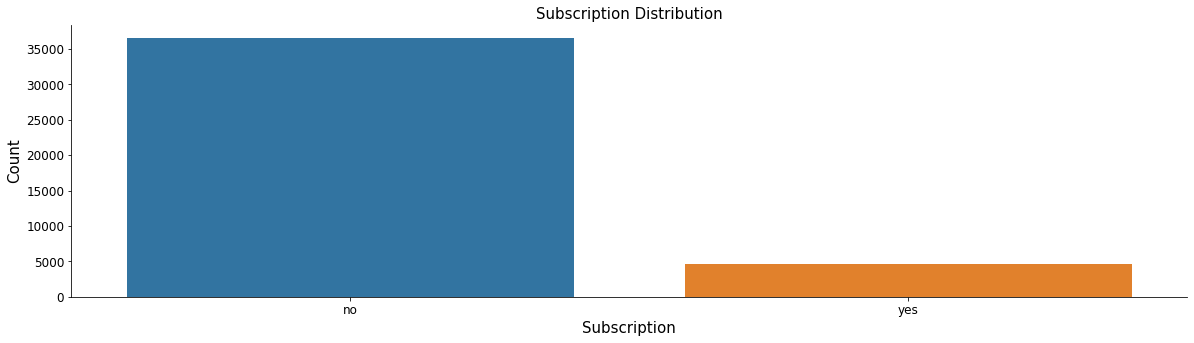

In [14]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.countplot(x = 'y', data = data, ax = ax1)
ax1.set_xlabel('Subscription', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Subscription Distribution', fontsize=15)
ax1.tick_params(labelsize=12)
sns.despine()


By plotting the subscription distribution, we could tell the dataset is unbalanced. There are only 4640 customers subscribe the deposit, while over 35000 customers did not subscribe.


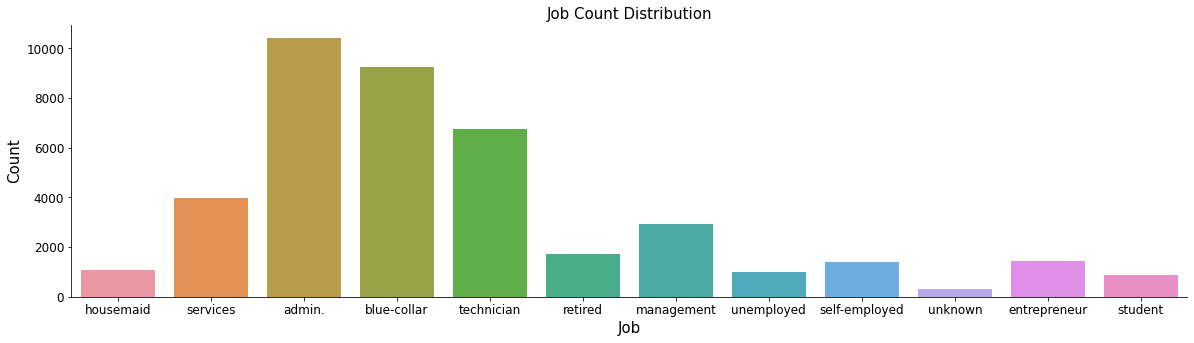

In [26]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.countplot(x = 'job', data = data, ax = ax1)
ax1.set_xlabel('Job', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Job Count Distribution', fontsize=15)
ax1.tick_params(labelsize=12)
sns.despine()


From the job distribution plot, we could tell that most campaign are targeted to administration role, blue-collar, and technician. Rarely campaign is to student, housemaid, and retired people. The reason might be bank is more willing to give campaign to whom have steady/high income.


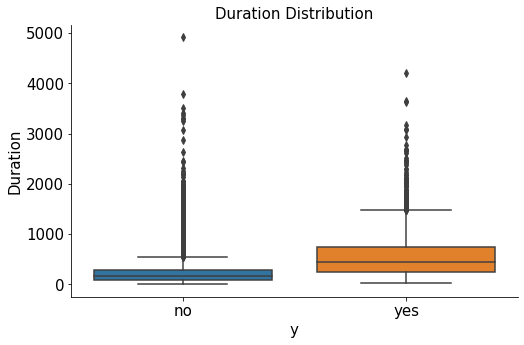

In [15]:
fig, ax1= plt.subplots(figsize=(8,5))
sns.boxplot(x='y', y='duration', data=data, ax=ax1)
ax1.set_xlabel('y', fontsize=15)
ax1.set_ylabel('Duration', fontsize=15)
ax1.set_title('Duration Distribution', fontsize=15)
ax1.tick_params(labelsize=15)
sns.despine()

The boxplot shows the last contact duration distribution between 2 subscription group of “yes” and “no”. We could tell people who subscribe a term deposit have longer contact duration than who do not subscribe.


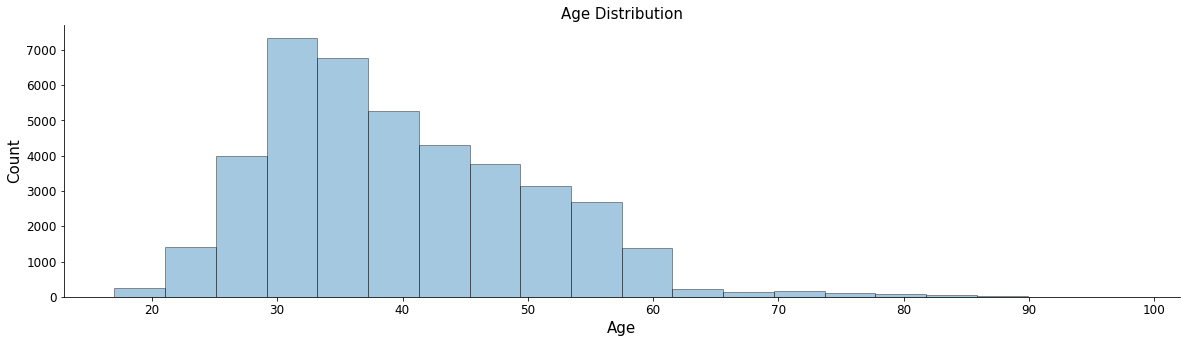

In [16]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.distplot(a = data['age'], hist=True, bins=20, kde=False, hist_kws={'edgecolor':'black'}, ax = ax1)
ax1.set_xlabel('Age', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Age Distribution', fontsize=15)
ax1.tick_params(labelsize=12)
sns.despine()

The age distribution is right skewed with long right tail. In historical marketing, most campaigns were targeted to people with age between 25-50.


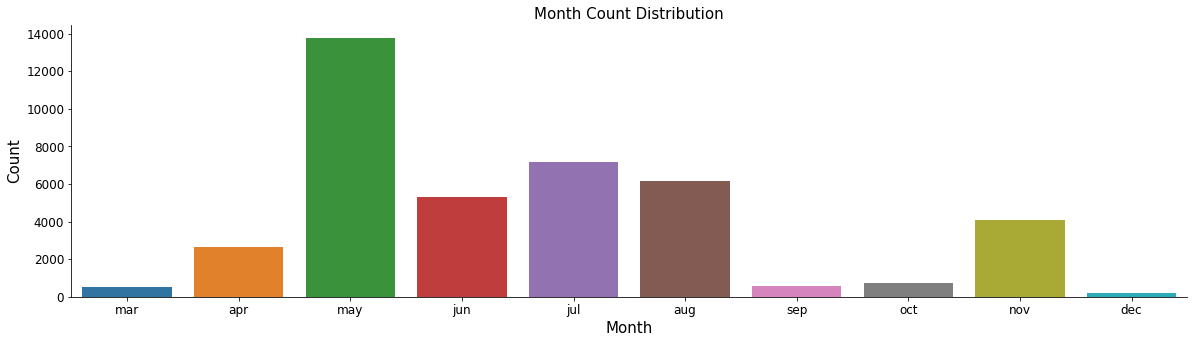

In [17]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.countplot(x = 'month', data = data, 
              order = ['mar', 'apr','may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ax = ax1)
ax1.set_xlabel('Month', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Month Count Distribution', fontsize=15)
ax1.tick_params(labelsize=12)
sns.despine()

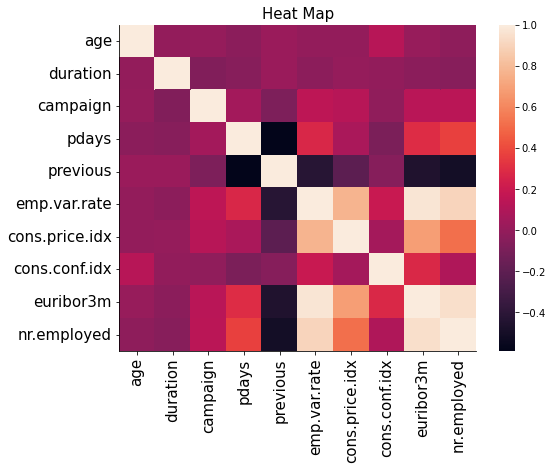

In [19]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.heatmap(data[var_num].corr())
ax1.tick_params(labelsize=15)
ax1.set_title('Heat Map', fontsize=15)
sns.despine()

The heat map is generated based on the numeric variables. From the plot, we could tell that there are high correlation between 'emp.var.rate'(employment variation rate), 'euribor3m'(euribor 3 month rate), 'nr.employed'(number of employees). 


### Part 3

Check missing value and find there is no missing

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

We perform data cleaning. Check code for details.
- First, we perform undersampling. We notice that the dataset is heavily imbalanced. There are 36549
samples labeled as 'no', and 4641 samples labeled as 'yes'. We undersample the dataset, and choose
4000 'yes' and 4000 'no' as our train-test set.
- Second, we perform categorical encoding. The features consist of number and categorical value. We
encode the categorical features.
- Third, we perform normalization. We standardize features by removing the mean and scaling to unit
variance.

In [20]:
def preprocess(df):
    # undersampling - to deal with imbalance dataset (around 9:1) 
    positive_df = df.loc[df['y'] == 'yes'].sample(n=4000, random_state=20)
    negative_df = df.loc[df['y'] == 'no'].sample(n=4000, random_state=20)

    df = pd.concat([positive_df, negative_df])
    df = df.sample(frac=1, random_state=20) # shuffle
    # df.to_csv('sample_data.csv')

    # categorical encoding
    month_to_num = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr': 4,
        'may': 5,
        'jun': 6,
        'jul': 7,
        'aug': 8,
        'sep': 9,
        'oct': 10,
        'nov': 11,
        'dec': 12
    }

    day_to_num = {
        'mon': 1,
        'tue': 2,
        'wed': 3,
        'thu': 4,
        'fri': 5
    }

    df['month'] = df['month'].map(month_to_num)
    df['day_of_week'] = df['day_of_week'].map(day_to_num)

    categorical_cols = ['job', 'marital', 'education', 'default', 
                        'housing', 'loan', 'contact', 'poutcome', 'y']
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    # normalization
    df.iloc[:,0:-1] = StandardScaler().fit_transform(df.iloc[:,0:-1].to_numpy())
    # df.to_csv('sample_data_preprocessed.csv')

    X = df.iloc[:,0:-1].values #ndarray (8000, 20)
    y = df['y'].values #ndarray (8000,)

    return X, y

In [21]:
X, y = preprocess(data)

### Part4

Function for calculate metric

In [26]:
def cal_metric(pred, label, y_score):
    acc = accuracy_score(label, pred)
    recall = recall_score(label, pred, average='macro')
    prec = precision_score(label, pred, average='macro')
    cm = confusion_matrix(label, pred)
    return acc, recall, prec, cm

We implement 2 machine learning models for our binary classification problem. 

One is support vector machine (SVM) classifier. It is commonly used in classification problems. In the SVM
algorithm, we plot each data item as a point in n-dimensional space (where n is a number of features)
with the value of each feature being the value of a particular coordinate. Then, we perform classification
by finding the hyper-plane that differentiates the two classes very well. SVM works more efficient in high
dimensional spaces. Therefore, we think it is suitable to use SVM classifier for our task. Check code for
more details.

In [24]:
def svm_classifier(X_train, X_test, y_train, y_test):
    print('SVM model ...')
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)

    pred_cls, pred_prob = clf.predict(X_test), clf.predict_proba(X_test)
    acc, recall, prec, cm = cal_metric(pred_cls, y_test, pred_prob)
    print(f'Accuracy: {acc : 0.5f}')
    print(f'Precision: {prec : 0.5f}')
    print(f'Recall: {recall : 0.5f}')
    print(f'Confusion Matrix:')
    print(cm)
    plot_roc_curve(clf, X_test, y_test) 
    plt.show()

Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

SVM model ...
Accuracy:  0.87167
Precision:  0.87418
Recall:  0.87163
Confusion Matrix:
[[ 996  203]
 [ 105 1096]]


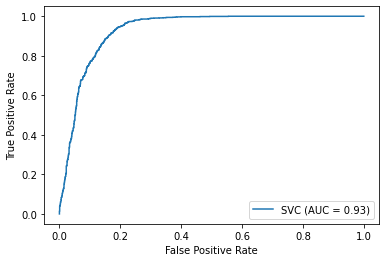

In [28]:
svm_classifier(X_train, X_test, y_train, y_test)

Another is multi-layer perceptron(MLP) classifier. MLP classifier relies on an underlying neural network to
perform the task of classification. Its multiple layers and non-linear activation distinguish MLP from a linear
perceptron. It can distinguish data that is not linearly separable. Therefore, we think it is suitable to use MLP
classifier for our task.
We build a MLP classifier with 2 hidden layers. The first hidden layer has 128 units and the second one has 128
units. Check code for more details.

In [30]:
def mlp(X_train, X_test, y_train, y_test):
    print('MLP model ...')
    clf = MLPClassifier(hidden_layer_sizes=([128, 128]), random_state=1, max_iter=500).fit(X_train, y_train)
    clf.fit(X_train, y_train)

    pred_cls, pred_prob = clf.predict(X_test), clf.predict_proba(X_test)
    acc, recall, prec, cm = cal_metric(pred_cls, y_test, pred_prob)
    print(f'Accuracy: {acc : 0.5f}')
    print(f'Precision: {prec : 0.5f}')
    print(f'Recall: {recall : 0.5f}')
    print(f'Confusion Matrix:')
    print(cm)
    plot_roc_curve(clf, X_test, y_test) 
    plt.show()

MLP model ...
Accuracy:  0.83792
Precision:  0.83797
Recall:  0.83791
Confusion Matrix:
[[ 997  202]
 [ 187 1014]]


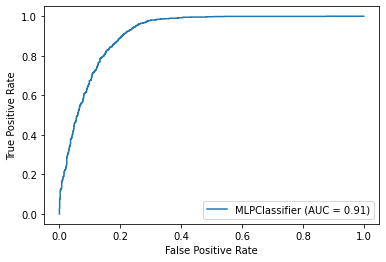

In [29]:
mlp(X_train, X_test, y_train, y_test)

By analyzing the results above, we notice that SVM classifier (0.87) has better performance (higher accuracy/precision/recall) than MLP classifier (0.8379), which matches our expectation. Because the training set is small (5600 samples), it is more prone to overfitting in MLP classifier. SVM tend to be more resistant to overfitting. Therefore, SVM classifier may perform better than MLP classifier.

### PartB-5
#### Hyperparameter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1,1, 10], 'gamma': [0.1, 0.05, 0.01],'kernel': ['rbf', 'poly', 'sigmoid']}
 
grid = GridSearchCV(svm.SVC(random_state=162), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.847, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.852, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.862, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.849, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.839, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.848, total=   0.5s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=162, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.05, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [32]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=162, shrinking=True, tol=0.001,
    verbose=False)


In [33]:
def opt_svm_classifier(X_train, X_test, y_train, y_test):
    print('Tuned SVM model ...')
    clf = svm.SVC(C=10, gamma=0.01, kernel='rbf', probability=True)
    clf.fit(X_train, y_train)

    pred_cls, pred_prob = clf.predict(X_test), clf.predict_proba(X_test)
    acc, recall, prec, cm = cal_metric(pred_cls, y_test, pred_prob)
    print(f'Accuracy: {acc : 0.5f}')
    print(f'Precision: {prec : 0.5f}')
    print(f'Recall: {recall : 0.5f}')
    print(f'Confusion Matrix:')
    print(cm)
    plot_roc_curve(clf, X_test, y_test) 
    plt.show()
    
    return clf

Tuned SVM model ...
Accuracy:  0.87750
Precision:  0.88038
Recall:  0.87746
Confusion Matrix:
[[1000  199]
 [  95 1106]]


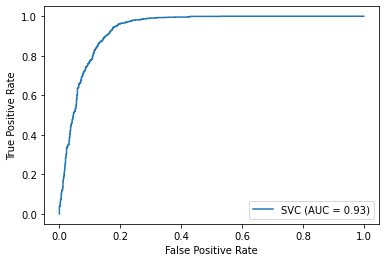

In [34]:
best_svm = opt_svm_classifier(X_train, X_test, y_train, y_test)

### MLP

In [35]:
mlp_param_grid = {
    'hidden_layer_sizes': [(128,32), (64,64), (128,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_grid = GridSearchCV(MLPClassifier(max_iter=200, random_state=162), mlp_param_grid, cv=3, verbose = 3) # n_jobs=-1
mlp_grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=sgd, score=0.853, total=   7.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=sgd, score=0.868, total=   7.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=sgd, score=0.853, total=   7.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(128, 32), learning_rate=constant, solver=adam, score=0.848, total=   8.4s
[CV] act

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['

In [36]:
# print best parameter after tuning
print(mlp_grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(mlp_grid.best_estimator_)

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'solver': 'adam'}
MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=162, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [37]:
def opt_mlp(X_train, X_test, y_train, y_test):
    print('Tuned MLP model ...')
    clf = MLPClassifier(activation='tanh', hidden_layer_sizes=(128,), solver = 'adam', alpha = 0.05,
              learning_rate='constant', random_state=162, max_iter=500)
    clf.fit(X_train, y_train)

    pred_cls, pred_prob = clf.predict(X_test), clf.predict_proba(X_test)
    acc, recall, prec, cm = cal_metric(pred_cls, y_test, pred_prob)
    print(f'Accuracy: {acc : 0.5f}')
    print(f'Precision: {prec : 0.5f}')
    print(f'Recall: {recall : 0.5f}')
    print(f'Confusion Matrix:')
    print(cm)
    plot_roc_curve(clf, X_test, y_test) 
    plt.show()   

Tuned MLP model ...
Accuracy:  0.85458
Precision:  0.85489
Recall:  0.85457
Confusion Matrix:
[[1007  192]
 [ 157 1044]]


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


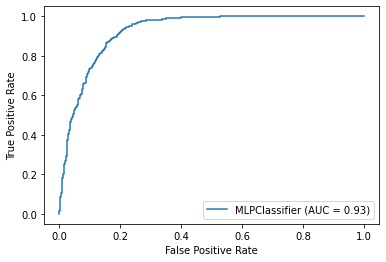

In [38]:
opt_mlp(X_train, X_test, y_train, y_test)

In part 5, we did hyperparameter tuning for Support Vector Machine (SVM) and multiple layer perceptron (MLP) models.
For SVM model, we tuned 3 parameters (C, gamma, kernel).
C: regularization(penalty) parameter. It represents how much misclassification is tolerant. If C is high, less misclassification, but high chance of overfitting. 
Kernel: kernel function in SVM, which could transform low-dimension inputs into high-dimension to get more accurate classifier. We tuned 3 different useful non-linear kernels. ['rbf', 'poly', 'sigmoid']
Gamma: kernel coefficient. It measures how far influence the decision boundary. High gamma means near points have high influence.
After tuning, when penalty parameter C=1 and kernel is radial basis function with 0.05 gamma, the model performs best. 

For MLP model, we tuned 5 parameters (hidden_layer_sizes, activation, alpha, learning_rate, solver).
hidden_layer_sizes: This parameter is to set the number of layers in the neural network and the number of nodes in each layer.
activation: The activation function for the hidden layer. i.e. transformation function before the output in each layer
alpha: regularization parameter
learning_rate: the learning rate of weight updates
solver: weight optimization algorithm
After tuning, the model chooses 1-layer neural network with 128 nodes in each layer with tanh activation function, adam weight optimization algorithm with constant learning_rate, and alpha(regularization parameter)= 0.0001.
After applying both model on the test set, we found SVM model has better prediction performance with over 0.87 accuracy, precision and recall.
Thus, we will use Support Vector Machine (SVM) model for bank marketing campaign to predict if the client will subscribe a term deposit.

